In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Read datasets

In [2]:
# This file tells to which set (prior, train, test) an order belongs.
# You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

# COLUMNS:
# order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
orders = pd.read_csv('./data/orders.csv',index_col = 'order_id')

In [106]:
orders.head(20)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,NaN
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0
3367565,1,prior,6,2,7,19.0
550135,1,prior,7,1,9,20.0
3108588,1,prior,8,1,14,14.0
2295261,1,prior,9,1,16,0.0


In [4]:
# These files specify which products were purchased in each order.
# order_products__prior.csv contains previous order contents for all customers.
# 'reordered' indicates that the customer has a previous order that contains the product. 
# Note that some orders will have no reordered items.
# You may predict an explicit 'None' value for orders with no reordered items.
# See the evaluation page for full details.

# COLUMNS
# order_id,product_id,add_to_cart_order,reordered 
train = pd.read_csv('./data/order_products__train.csv')
prior = pd.read_csv('./data/order_products__prior.csv')

Additional information

Пока не ясно, как эта информация может быть использована.

In [5]:
products    = pd.read_csv('./data/products.csv',index_col='product_id')
aisles      = pd.read_csv('./data/aisles.csv',index_col = 'aisle_id')
departments = pd.read_csv('./data/departments.csv', index_col = 'department_id')

В целом, что можно делать?

Ответ на какой вопрос:

Сгруппировать покупки по пользователю и по заказу

В тестовых заказах известна часть продуктов. Надо указать, какие ещё продукты будут дозаказаны.
Можно для каждого пользователя и продукта обучить классификатор, который будет отвечать на вопрос - купить ли пользователь это? 
Итого: на выходе требуется указать id продуктов, которые будут куплены.
Итого, это может быть классификатор. Либо глубокая нейронная сеть.

Для чего нужны проходы? Наверное, покупка одного продукта из прохода увеличивает вероятность покупки продукта из того же прохода.

Baseline решение:
найти наиболее частые группы товаров и проверить точность решения. Для этого можно использовать биграммы.
Для начала попробуем сгруппировать продукты по пользователям и товарам.

Попробовать объединить train и preorder в один сет. Добавить поля название продукта, пользователь, order_id, eval_set, order_number etc из таблицы orders. Сгруппировать по пользователям (первые уровень) и заказам (второй уровень).

In [6]:
def addFeatures(df):
    priorSet = df.merge(products, left_on='product_id', right_index=True, how = 'left', copy = False)
    priorSet = priorSet.merge(aisles, left_on = 'aisle_id',right_index = True, how = 'left', copy = False)
    priorSet = priorSet.merge(departments, left_on = 'department_id', right_index = True, how = 'left', copy = False)
    priorSet = priorSet.merge(orders, left_on = 'order_id', right_index = True, how = 'left', copy = False)
    return priorSet

Как реализовать скрипт?

<b> Baseline решение - самые популярные продукты из его корзины </b>

Для каждого пользователя считаем:

1) <u>средний размер корзины</u>
Для этого группируем таблицу prior по 1) пользователям; 2) заказам. 
Исключаем train заказы
Вычисляем средний размер (GroupBy object, .size().mean() )
@TODO - проверить точность модели для разных способов округления среднего размера корзины;

2) <u>самые популярные продукты</u>
Группируем таблицу prior по 1) пользователям; 2) продуктам. Считаем статистику по продуктам, сортируем.

In [97]:
def basketSize(userGroup):
    g = userGroup.groupby(['order_id'])
    return g['order_id'].size().mean()

In [57]:
def save2File(fName,df):
    f = open(fName,'w')
    f.write('order_id,products\n')
    np.set_printoptions(linewidth = 500)
    for key, val in df.iteritems():
        k = np.array2string(val[1])[1:-1]+'\n'
        s = str(val[0])+','+k
        f.write(s)
    f.close()
    np.set_printoptions(linewidth = 75)

In [ ]:
testUserId = orders.query("eval_set == 'test'").user_id.values
testPriorOrderId = orders.query("(eval_set =='prior') and user_id in @testUsers").index.values
testPriorSet = prior.query('order_id in @testPriorOrderId')

Сохранять результаты в dateframe вида

1) user_id

2) order_id

3) prediction

4) test

In [244]:
trainDf = pd.DataFrame(columns = ['user_id','order_id','prediction','real'])

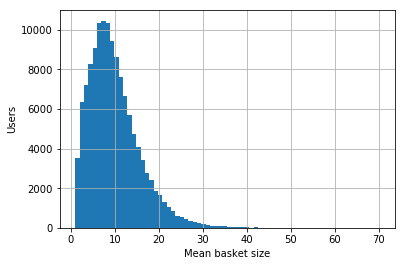

In [270]:
targetGroup = 'train'

userId = orders.query("eval_set == @targetGroup").user_id.values
priorOrderId = orders.query("(eval_set =='prior') and user_id in @userId").index.values
priorSet = prior.query('order_id in @priorOrderId')
#trainPriorSet = addFeatures(trainPriorSet)
priorSet = priorSet.merge(orders.loc[:,['user_id','order_number']],left_on='order_id',right_index=True,copy= False)

# calculate basket size
bs = priorSet.groupby('user_id').aggregate(basketSize)['order_id']
bs.rename('basket_size',inplace=True);

# plot basket size
bs.hist(bins = 70);
plt.xlabel('Mean basket size')
plt.ylabel('Users')

# calculate most popular goods
prod = priorSet.groupby(['user_id','product_id']).order_id.size().to_frame(name = 'count')
prod = prod.reset_index(level=1)
prod = prod.reset_index(level=0)

# reindex orders dataframe
orders2 = orders.query("(user_id in @userId) and (eval_set == @targetGroup)").reset_index().set_index('user_id')

In [272]:
# create final set
res = dict()
for user_id, basket in prod.groupby('user_id'):
    #print user_id
    order_id = orders2.loc[user_id].order_id
    trainDf = trainDf.append({'user_id':  user_id,
                    'order_id': order_id,
                    'prediction': basket.sort_values('count',ascending=False).head(int(np.floor(bs.get(user_id)))).product_id.values,
                    'real': train.query('order_id == @order_id').product_id.values},
                   ignore_index = True)

trainDf.to_pickle('train_solution.pcl')    
#save2File('solution3.csv',res)

In [162]:
res = np.empty([0,5])
for user_id, val in resTrain.iteritems():
    order_id = val[0]
    y_pr = val[1]
    y_true = train.query('order_id == @order_id').product_id.values
    [precession, recall, f1] = f1Score(y_true,y_pr)
    res = np.vstack([res,[user_id, order_id, precession, recall, f1]])

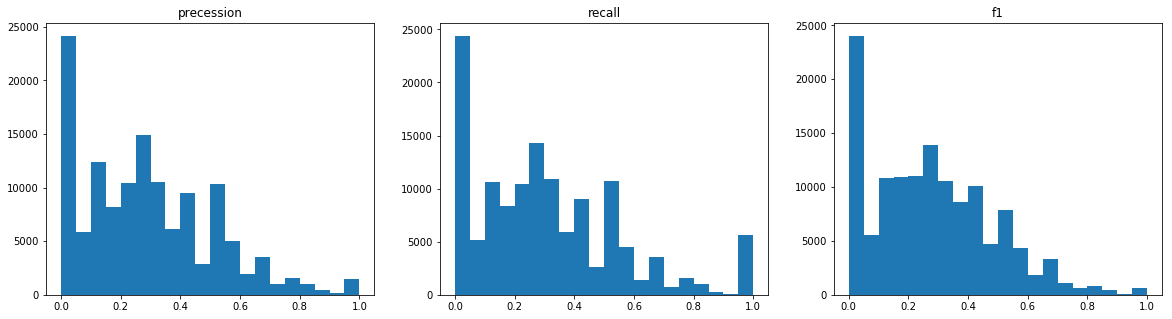

In [180]:
plt.figure(figsize=[20,5])

plt.subplot(131)
plt.hist(res[:,2],bins = 20);
plt.title('precession')

plt.subplot(132)
plt.hist(res[:,3],bins = 20);
plt.title('recall')

plt.subplot(133)
plt.hist(res[:,4],bins = 20);
plt.title('f1')

In [276]:
trainDf.head()

,user_id,order_id,prediction,real
0,1.0,1187899.0,"[196, 12427, 10258, 25133, 46149]","[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2.0,1492625.0,"[32792, 47209, 24852, 18523, 1559, 19156, 1200...","[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,5.0,2196797.0,"[11777, 26604, 43693, 24535, 21413, 8518, 4070...","[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,7.0,525192.0,"[40852, 37602, 17638, 21137, 31683, 13198, 492...","[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,8.0,880375.0,"[2078, 23165, 17794, 21903, 34358, 28985, 3203...","[15937, 5539, 10960, 23165, 22247, 4853, 27104..."


In [275]:
trainDf = trainDf.assign(f1 = f1Score(trainDf.real,trainDf.prediction))

ValueError: all the input arrays must have same number of dimensions

In [324]:
def f1Score(y_true, y_pred):
    fullSet      = np.unique(np.hstack((y_pred,y_true)))
    intersection = np.intersect1d(y_true,y_pred).size
    precession   = intersection/float(y_pred.shape[0])
    recall       = intersection/float(y_true.shape[0])
    try:
        f1 = 2*precession*recall/(precession+recall)
    except ZeroDivisionError:
        f1 = 0
    #return [precession, recall, f1]
    return f1

def mf(row):
    return f1Score(row['real'], row['prediction'])

In [327]:
trainDf = trainDf.assign(f1 = trainDf.apply(mf, axis = 1))

In [330]:
trainDf.f1.mean()

0.2715735739162299